### Import der Bibliotheken



In [258]:
# Importieren der notwendigen Bibliotheken
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
import warnings

warnings.filterwarnings("ignore")


### Top 10 Coins nach Marketcap

In [259]:
def fetch_top_10_coins():
    """Fetches the top 10 coins by market cap from CoinGecko and excludes blacklisted pairs."""
    url = "https://api.coingecko.com/api/v3/coins/markets"
    params = {
        "vs_currency": "usd",
        "order": "market_cap_desc",
        "per_page": 10,
        "page": 1,
        "sparkline": False
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        
        # Blacklist for unwanted pairs
        blacklist = ["USDT", "STETH"]
        
        # Filter coins: exclude symbols in blacklist
        coins = [
            {"Symbol": coin["symbol"].upper(), "Name": coin["name"], "Market Cap": coin["market_cap"]}
            for coin in data if coin["symbol"].upper() not in blacklist
        ]
        return pd.DataFrame(coins)
    else:
        print("Fehler beim Abrufen der Daten:", response.status_code)
        return None


### Historische daten - Abrufen der Daten

In [260]:
def fetch_historical_data_complete(symbol, interval="15m", days=180):
    """Fetch historical crypto data from Binance."""
     # Blacklist unwanted pairs
    blacklist = ["USDTUSDT", "STETHUSDT"]
    if symbol.upper() in blacklist:
        print(f"Symbol {symbol} ist geblacklistet. Überspringe...")
        return None
    base_url = "https://api.binance.com/api/v3/klines"
    end_time = int(datetime.now().timestamp() * 1000)  # Current time in ms
    start_time = int((datetime.now() - timedelta(days=days)).timestamp() * 1000)  # Start time in ms

    all_data = []
    while start_time < end_time:
        params = {
            "symbol": symbol.upper(),
            "interval": interval,
            "startTime": start_time,
            "endTime": end_time,
            "limit": 1000,
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            if not data:
                break
            all_data.extend(data)
            start_time = data[-1][6]
        else:
            print(f"Error fetching data for {symbol}: {response.status_code}")
            break

    df = pd.DataFrame(all_data, columns=[
        "Open Time", "Open", "High", "Low", "Close", "Volume",
        "Close Time", "Quote Asset Volume", "Number of Trades",
        "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore"
    ])
    df["Open Time"] = pd.to_datetime(df["Open Time"], unit="ms")
    df["Close Time"] = pd.to_datetime(df["Close Time"], unit="ms")

    return df[["Open Time", "Open", "Close", "High", "Low"]]


### Lokale Speicherung/Laden

In [261]:
def fetch_or_load_historical_data(file_path, interval="15m", days=180):
    # Sicherstellen, dass das Verzeichnis existiert
    ensure_directory_exists(os.path.dirname(file_path))

    # Laden der Daten, wenn die Datei existiert
    if os.path.exists(file_path):
        print(f"Lade historische Daten aus {file_path}...")
        return pd.read_csv(file_path)

    # Abrufen der historischen Daten, wenn die Datei nicht existiert
    coin_data = fetch_historical_data_complete(file_path, interval=interval, days=days)
    if coin_data is not None:
        coin_data.to_csv(file_path, index=False)
        print(f"Historische Daten für {file_path} gespeichert.")
    return coin_data


### Berechnung der technischen Indikatoren

In [262]:
def calculate_indicators(coin_data):
    """Calculate RSI, MACD, and Bollinger Bands."""
    for column in ["Open", "Close", "High", "Low"]:
        coin_data[column] = pd.to_numeric(coin_data[column], errors="coerce")
    
    # RSI
    coin_data["RSI"] = RSIIndicator(close=coin_data["Close"], window=14).rsi()
    
    # MACD
    macd = MACD(close=coin_data["Close"])
    coin_data["MACD"] = macd.macd()
    coin_data["Signal"] = macd.macd_signal()
    
    # Bollinger Bands
    bb = BollingerBands(close=coin_data["Close"])
    coin_data["BB Upper"] = bb.bollinger_hband()
    coin_data["BB Lower"] = bb.bollinger_lband()
    
    return coin_data


### Backtesting-Logik

In [263]:
import pandas as pd
import numpy as np
import os
import pandas as pd

def simulate_long_trades(data, params, debug=False):
    """
    Simuliert Long Trades basierend auf flexiblen Parametern und Bedingungen.
    
    Parameters:
        data (DataFrame): Historische Daten mit Indikatoren (RSI, MACD, etc.).
        params (dict): Dictionary mit Parametern wie RSI, MACD, Take-Profit, Stop-Loss.
        debug (bool): Wenn True, werden Debugging-Informationen ausgegeben.
    
    Returns:
        trades (DataFrame): Enthält die Trades mit Entry- und Exit-Daten.
        performance (dict): Performance-Metriken wie Netto-Gewinn, Trefferquote, etc.
    """
    # Parameter extrahieren
    rsi_threshold = params.get('rsi_threshold', 30)
    take_profit = params.get('take_profit', 0.02)
    stop_loss = params.get('stop_loss', 0.01)
    trailing_stop_loss = params.get('trailing_stop_loss', None)
    
    # Initialisierung
    trades = []
    position_open = False
    entry_price = 0
    highest_price = 0

    # Iteriere durch die historischen Daten
    for i, row in data.iterrows():
        close_price = row['Close']

        # Debugging: Zeige aktuelle Werte
        if debug:
            print(f"Row {i}: Close: {close_price:.2f}, RSI: {row.get('RSI', np.nan):.2f}, MACD: {row.get('MACD', np.nan):.2f}, Signal: {row.get('Signal', np.nan):.2f}")
        
        # Einstiegskriterien prüfen
        if not position_open:
            if (row['RSI'] < rsi_threshold and 
                row['MACD'] > row['Signal'] and 
                close_price <= row['BB Lower']):
                # Position öffnen
                position_open = True
                entry_price = close_price
                highest_price = close_price
                trades.append({
                    "Type": "Buy",
                    "Price": entry_price,
                    "Time": row['Open Time']
                })
                if debug:
                    print(f"Buy at {entry_price:.2f} on {row['Open Time']}")
            continue

        # Ausstiegskriterien prüfen, wenn Position offen
        if position_open:
            profit = (close_price - entry_price) / entry_price

            # Trailing Stop-Loss
            if trailing_stop_loss:
                highest_price = max(highest_price, close_price)
                trailing_exit_price = highest_price * (1 - trailing_stop_loss)
                if close_price <= trailing_exit_price:
                    position_open = False
                    trades.append({
                        "Type": "Sell",
                        "Price": close_price,
                        "Time": row['Open Time'],
                        "Reason": "Trailing Stop"
                    })
                    if debug:
                        print(f"Sell (Trailing Stop) at {close_price:.2f} on {row['Open Time']}")
                    continue

            # Take-Profit oder Stop-Loss
            if profit >= take_profit or profit <= -stop_loss:
                position_open = False
                trades.append({
                    "Type": "Sell",
                    "Price": close_price,
                    "Time": row['Open Time'],
                    "Reason": "TP/SL"
                })
                if debug:
                    print(f"Sell (TP/SL) at {close_price:.2f} on {row['Open Time']}")
                continue

    # Berechnung der Performance
    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df['Profit'] = trades_df['Price'].diff().fillna(0)
        net_profit = trades_df['Profit'].sum()
        winrate = len(trades_df[trades_df['Profit'] > 0]) / len(trades_df) if len(trades_df) > 0 else 0
        max_drawdown = trades_df['Profit'].cumsum().cummax().sub(trades_df['Profit'].cumsum()).max()
    else:
        net_profit = 0
        winrate = 0
        max_drawdown = 0

    performance = {
        "Net Profit": net_profit,
        "Winrate": winrate,
        "Max Drawdown": max_drawdown,
    }

    return trades_df, performance

def save_backtesting_results(trades, file_path):
    """
    Speichert Backtesting-Ergebnisse (Trades) in einer Datei.
    
    Parameters:
        trades (DataFrame): DataFrame mit den Trades.
        file_path (str): Pfad zur Datei, in der die Trades gespeichert werden sollen.
    """
    os.makedirs(os.path.dirname(file_path), exist_ok=True)  # Erstelle das Verzeichnis, falls es nicht existiert
    trades.to_csv(file_path, index=False)
    print(f"Backtesting-Ergebnisse gespeichert in {file_path}.")

def load_backtesting_results(file_path):
    """
    Lädt Backtesting-Ergebnisse (Trades) aus einer Datei, falls vorhanden.
    
    Parameters:
        file_path (str): Pfad zur CSV-Datei mit den Backtesting-Ergebnissen.

    Returns:
        DataFrame: DataFrame mit den geladenen Trades, oder None, falls die Datei nicht existiert.
    """
    if os.path.exists(file_path):
        print(f"Lade Backtesting-Ergebnisse aus {file_path}...")
        return pd.read_csv(file_path)
    else:
        print(f"Backtesting-Ergebnisse für {file_path} nicht gefunden.")
        return None


# Beispiel-Aufruf
example_params = {
    "rsi_threshold": 30,
    "take_profit": 0.03,
    "stop_loss": 0.01,
    "trailing_stop_loss": 0.02
}

# Hier könntest du Daten einfügen: `data` sollte ein DataFrame mit Indikatoren sein.
# Beispiel:
# trades, performance = simulate_long_trades(data, example_params, debug=True)



### Dictionary

In [264]:
param_ranges = {
    "rsi_threshold": [20, 25, 30, 35, 40],
    "take_profit": [0.02, 0.03, 0.05],
    "stop_loss": [0.01, 0.02, 0.03],
    "trailing_stop_loss": [None, 0.02, 0.03]
}


### Berechnung der Performance

In [265]:
def calculate_performance(trades, initial_balance=1000):
    """
    Calculates the performance of the backtesting.

    Parameters:
        trades (DataFrame): The trade details.
        initial_balance (float): Starting capital.

    Returns:
        dict: Performance metrics (e.g., Net Profit, Winrate).
    """
    balance = initial_balance
    wins = 0
    losses = 0

    for i in range(0, len(trades), 2):  # Iteriere über Buy-Sell-Paare
        if i + 1 < len(trades):
            entry = trades.iloc[i]["Price"]
            exit = trades.iloc[i + 1]["Price"]
            profit = (exit - entry) / entry
            balance += balance * profit

            if profit > 0:
                wins += 1
            else:
                losses += 1

    winrate = wins / (wins + losses) if (wins + losses) > 0 else 0

    return {
        "Net Profit": balance - initial_balance,
        "Winrate": winrate,
        "Trades": len(trades) // 2
    }


### Visualisierung der Kapitalkurve

In [266]:
def plot_equity_curve(trades, initial_balance=1000):
    """
    Plots the equity curve over the trades.

    Parameters:
        trades (DataFrame): The trade details.
        initial_balance (float): Starting capital.
    """
    balance = initial_balance
    equity_curve = [balance]

    for i in range(0, len(trades), 2):  # Iteriere über Buy-Sell-Paare
        if i + 1 < len(trades):
            entry = trades.iloc[i]["Price"]
            exit = trades.iloc[i + 1]["Price"]
            profit = (exit - entry) / entry
            balance += balance * profit
            equity_curve.append(balance)

    plt.figure(figsize=(12, 6))
    plt.plot(equity_curve, label="Equity Curve", color="blue", linewidth=2)
    plt.title("Equity Curve")
    plt.xlabel("Trades")
    plt.ylabel("Balance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


### Optimierungmodul (Platzhalter)

In [267]:
from itertools import product
import matplotlib.pyplot as plt
import pandas as pd
import os

def optimize_parameters(data, debug=False, save_path="optimized_parameters.csv"):
    """
    Optimiert Trading-Parameter basierend auf der Backtesting-Logik.
    
    Parameters:
        data (DataFrame): Historische Daten mit Indikatoren (RSI, MACD, etc.).
        debug (bool): Gibt detaillierte Informationen aus, wenn True.
        save_path (str): Pfad zur CSV-Datei für das Speichern/Laden der optimierten Parameter.

    Returns:
        best_params (dict): Beste Parameterkombination mit Performance.
        results_df (DataFrame): Alle getesteten Parameterkombinationen und ihre Performance.
    """
    # Parameterbereiche definieren
    param_ranges = {
        "rsi_threshold": [20, 25, 30, 35, 40],
        "take_profit": [0.02, 0.03, 0.04, 0.05],
        "stop_loss": [0.01, 0.02, 0.03],
        "trailing_stop_loss": [None, 0.02, 0.03]
    }

    # Prüfen, ob optimierte Parameter bereits existieren
    if os.path.exists(save_path):
        print(f"Lade optimierte Parameter aus {save_path}...")
        results_df = pd.read_csv(save_path)
        best_params = results_df.iloc[results_df['Net Profit'].idxmax()].to_dict()
        return best_params, results_df

    # Initialisieren der Ergebnisse
    results = []
    best_params = None
    best_net_profit = -float("inf")

    # Erstellen aller Kombinationen von Parametern
    param_keys = param_ranges.keys()
    param_values = product(*param_ranges.values())

    for param_combination in param_values:
        # Parameterkombination als Dictionary
        params = dict(zip(param_keys, param_combination))

        # Backtesting mit der aktuellen Parameterkombination
        trades, performance = simulate_long_trades(data, params, debug=debug)
        result = {"params": params, **performance}
        results.append(result)

        # Beste Parameterkombination aktualisieren
        if performance["Net Profit"] > best_net_profit:
            best_net_profit = performance["Net Profit"]
            best_params = result

    # Ergebnisse als DataFrame
    results_df = pd.DataFrame(results)

    # Ergebnisse speichern
    results_df.to_csv(save_path, index=False)
    print(f"Optimierte Parameter gespeichert in {save_path}.")

    return best_params, results_df


def plot_optimization_results(results_df, x_param, y_param, metric="Net Profit"):
    """
    Visualisiert die Optimierungsergebnisse als Heatmap.

    Parameters:
        results_df (DataFrame): Ergebnisse der Optimierung.
        x_param (str): Parameter für die X-Achse der Heatmap.
        y_param (str): Parameter für die Y-Achse der Heatmap.
        metric (str): Zu visualisierende Metrik (z. B. 'Net Profit').
    """
    # Pivot-Table für die Heatmap erstellen
    pivot = results_df.pivot_table(values=metric, index=y_param, columns=x_param, aggfunc="mean")

    # Plot erstellen
    plt.figure(figsize=(12, 6))
    plt.title(f"Optimization Results ({metric})")
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.imshow(pivot, cmap="viridis", aspect="auto", origin="lower")
    plt.colorbar(label=metric)
    plt.tight_layout()
    plt.show()

def save_optimized_parameters(parameters, file_path="optimized_parameters.csv"):
    """
    Speichert die optimierten Parameter in einer CSV-Datei.
    
    Parameters:
        parameters (list): Eine Liste von Dictionaries mit den optimierten Parametern.
        file_path (str): Pfad zur CSV-Datei, in der die Parameter gespeichert werden.
    """
    pd.DataFrame(parameters).to_csv(file_path, index=False)
    print(f"Optimierte Parameter gespeichert in {file_path}.")


### Pipeline für mehrere Coins

Backtesting-Ergebnisse für backtesting_results/BTCUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/BTCUSDT_trades.csv.
Lade optimierte Parameter aus optimized_parameters.csv...
Abrufen oder Laden der Daten für BTCUSDT...
Lade historische Daten aus historical_data/BTCUSDT_15m.csv...
Optimierte Parameter für BTCUSDT gefunden: {'Coin': 'BTCUSDT', 'rsi_threshold': 40, 'take_profit': 0.05, 'stop_loss': 0.02, 'trailing_stop_loss': nan, 'Net Profit': 4730.160000000004, 'Winrate': 0.3125, 'Max Drawdown': 19602.120000000003}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Lade Backtesting-Ergebnisse aus backtesting_results/BTCUSDT_trades.csv...


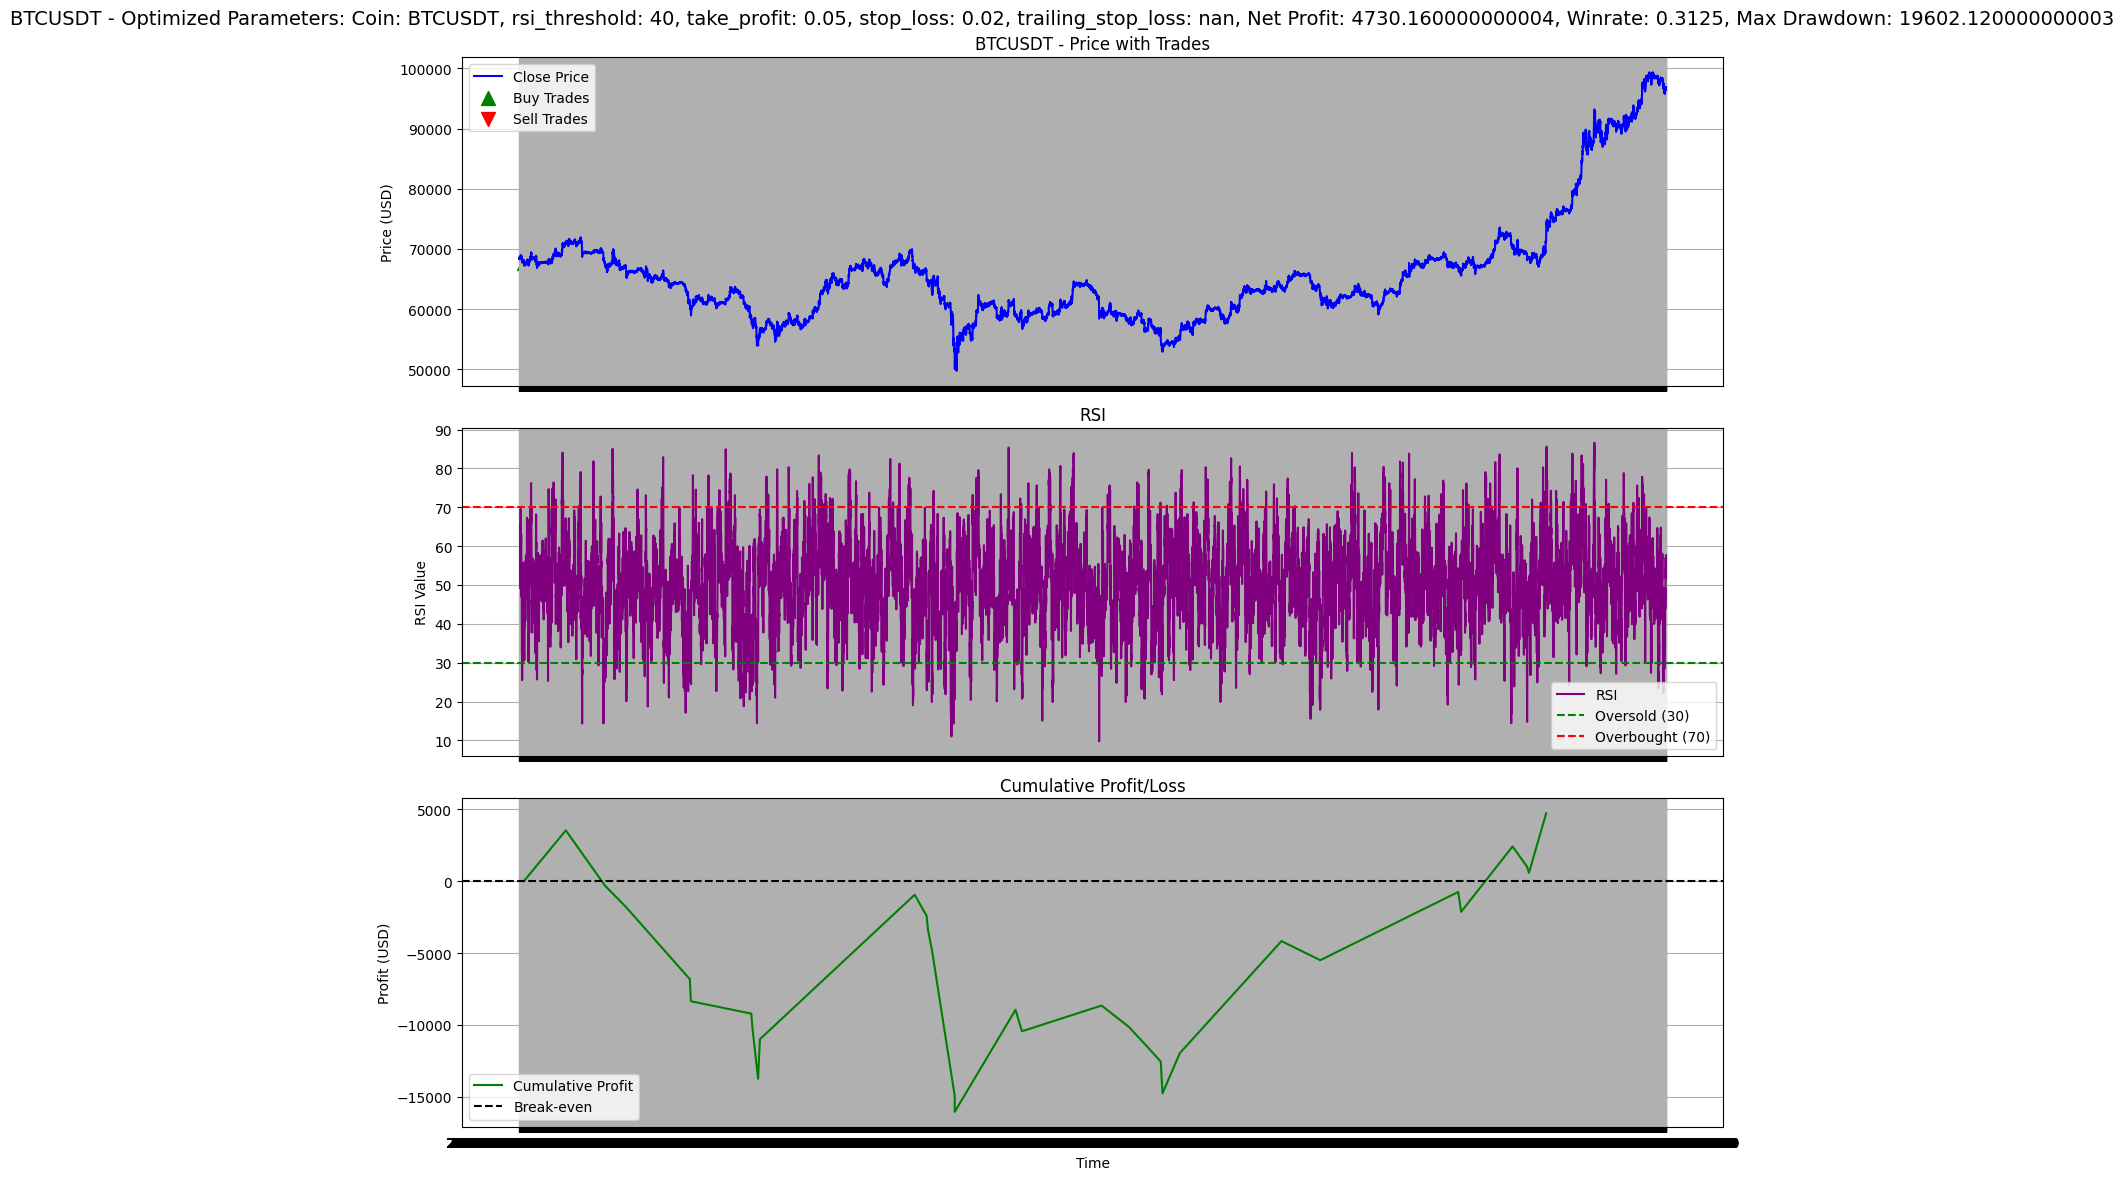

Abrufen oder Laden der Daten für ETHUSDT...
Lade historische Daten aus historical_data/ETHUSDT_15m.csv...
Optimierte Parameter für ETHUSDT gefunden: {'Coin': 'ETHUSDT', 'rsi_threshold': 20, 'take_profit': 0.02, 'stop_loss': 0.01, 'trailing_stop_loss': nan, 'Net Profit': 0.0, 'Winrate': 0.0, 'Max Drawdown': 0.0}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/ETHUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/ETHUSDT_trades.csv.
Warnung: Keine gültigen Trades für ETHUSDT.


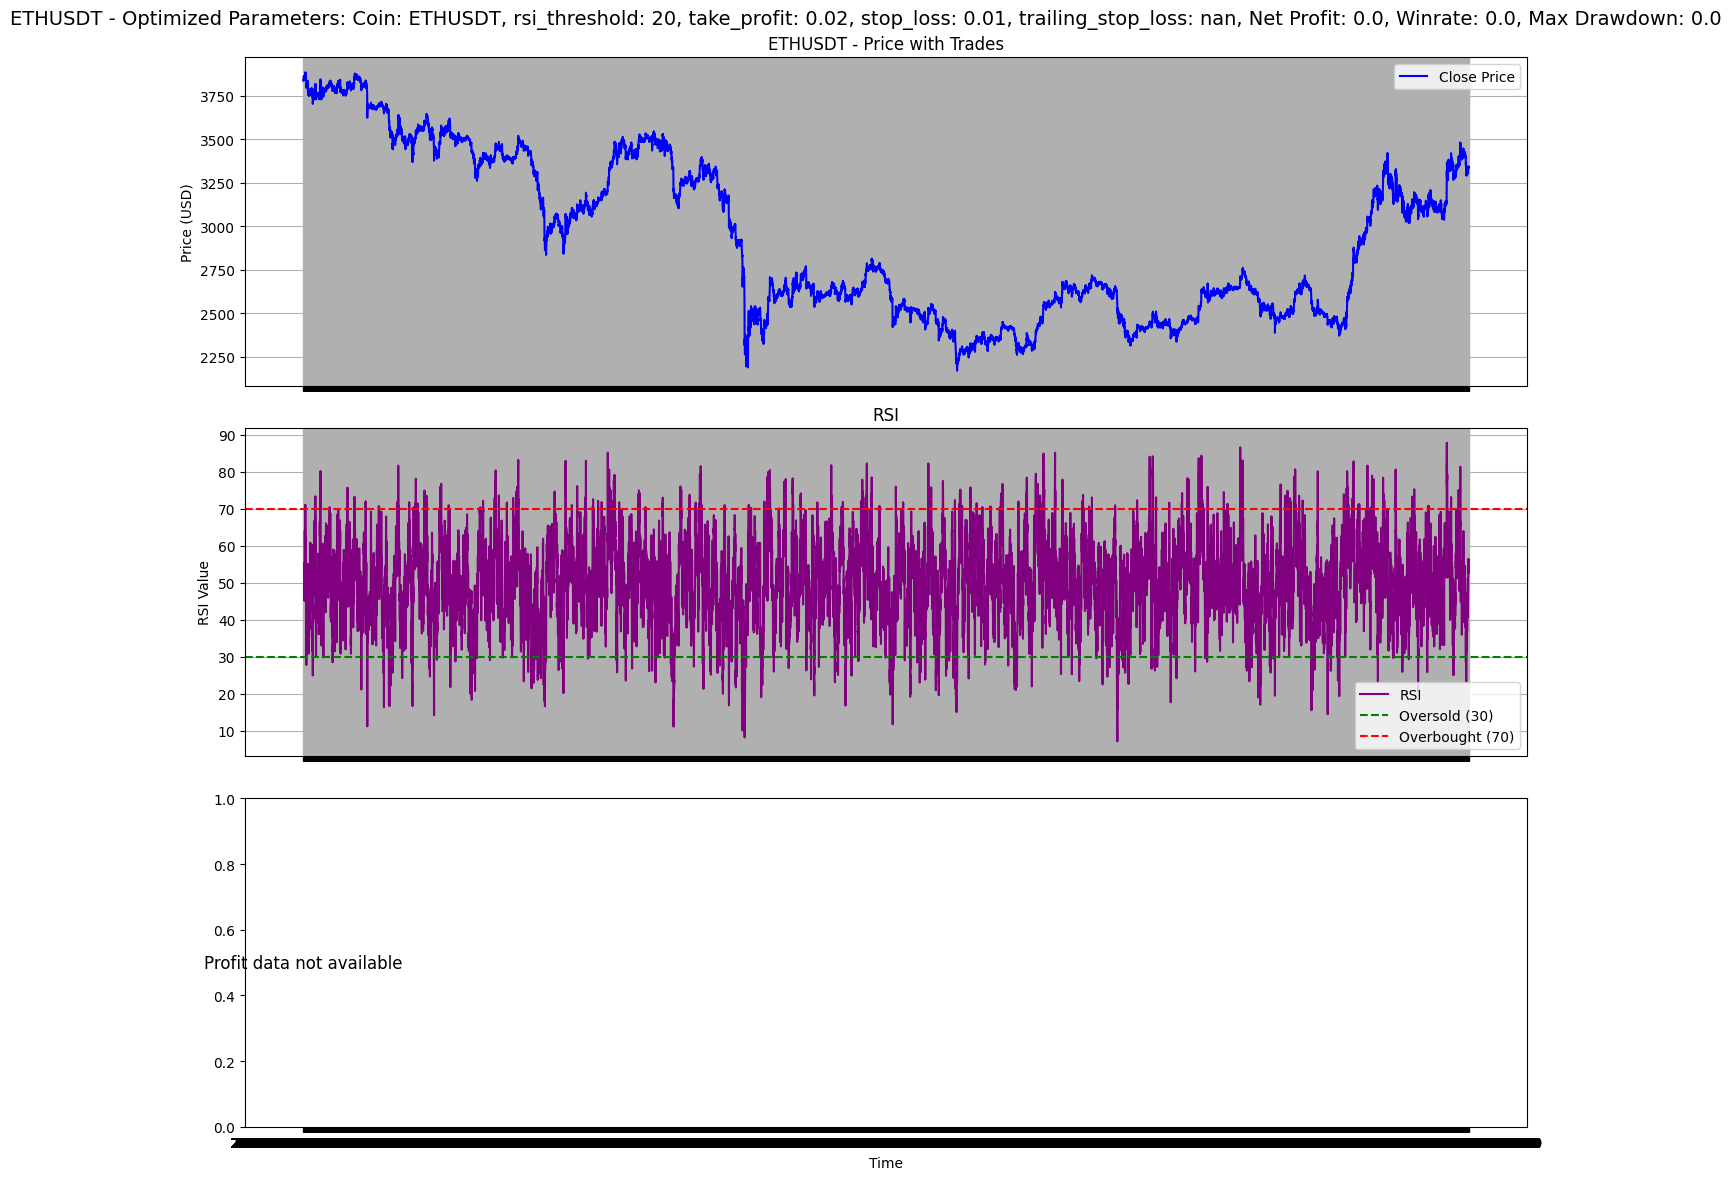

Abrufen oder Laden der Daten für SOLUSDT...
Lade historische Daten aus historical_data/SOLUSDT_15m.csv...
Optimierte Parameter für SOLUSDT gefunden: {'Coin': 'SOLUSDT', 'rsi_threshold': 40, 'take_profit': 0.05, 'stop_loss': 0.02, 'trailing_stop_loss': nan, 'Net Profit': 50.78, 'Winrate': 0.375, 'Max Drawdown': 44.99000000000001}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/SOLUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/SOLUSDT_trades.csv.


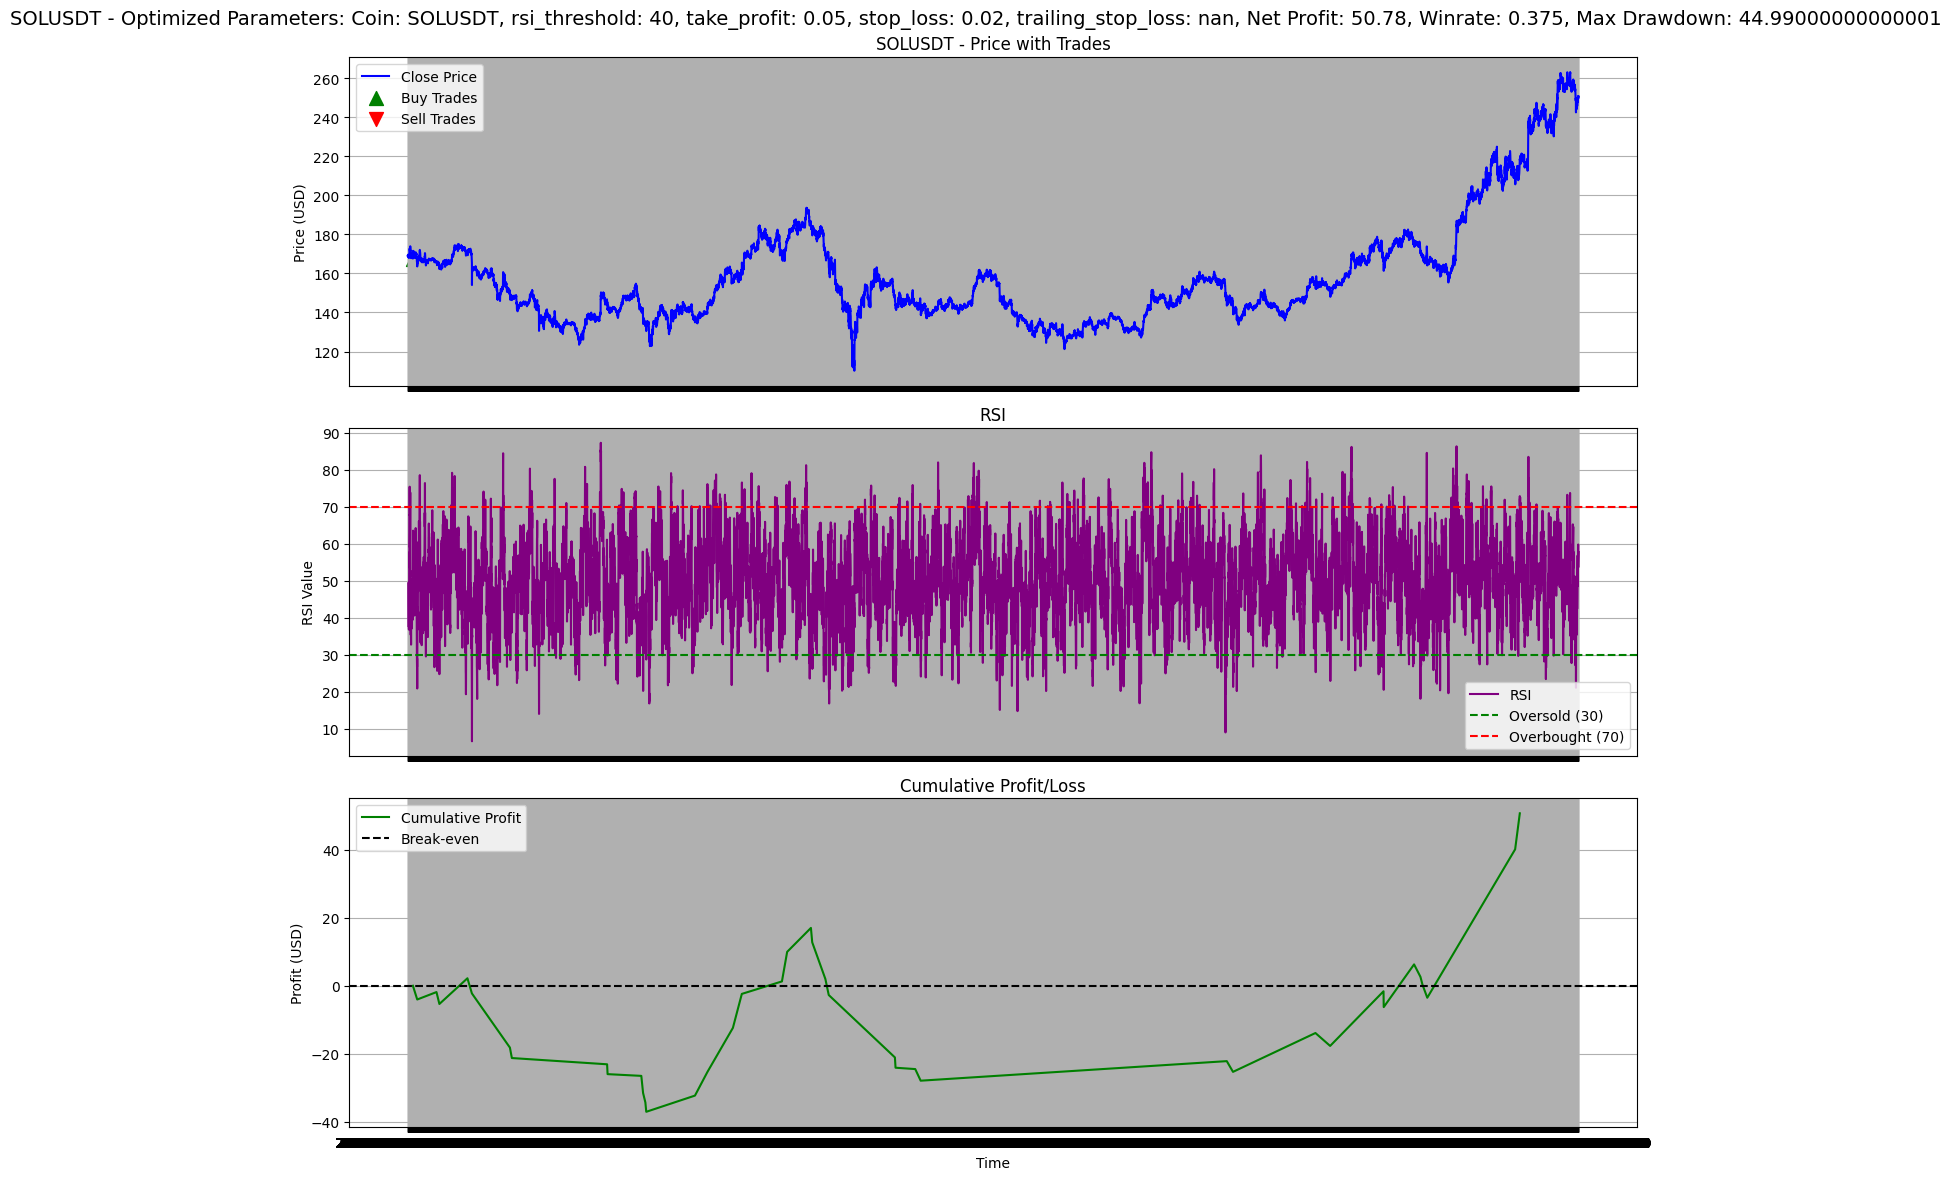

Abrufen oder Laden der Daten für BNBUSDT...
Lade historische Daten aus historical_data/BNBUSDT_15m.csv...
Optimierte Parameter für BNBUSDT gefunden: {'Coin': 'BNBUSDT', 'rsi_threshold': 40, 'take_profit': 0.05, 'stop_loss': 0.03, 'trailing_stop_loss': nan, 'Net Profit': 68.0200000000001, 'Winrate': 0.3125, 'Max Drawdown': 214.9}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/BNBUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/BNBUSDT_trades.csv.


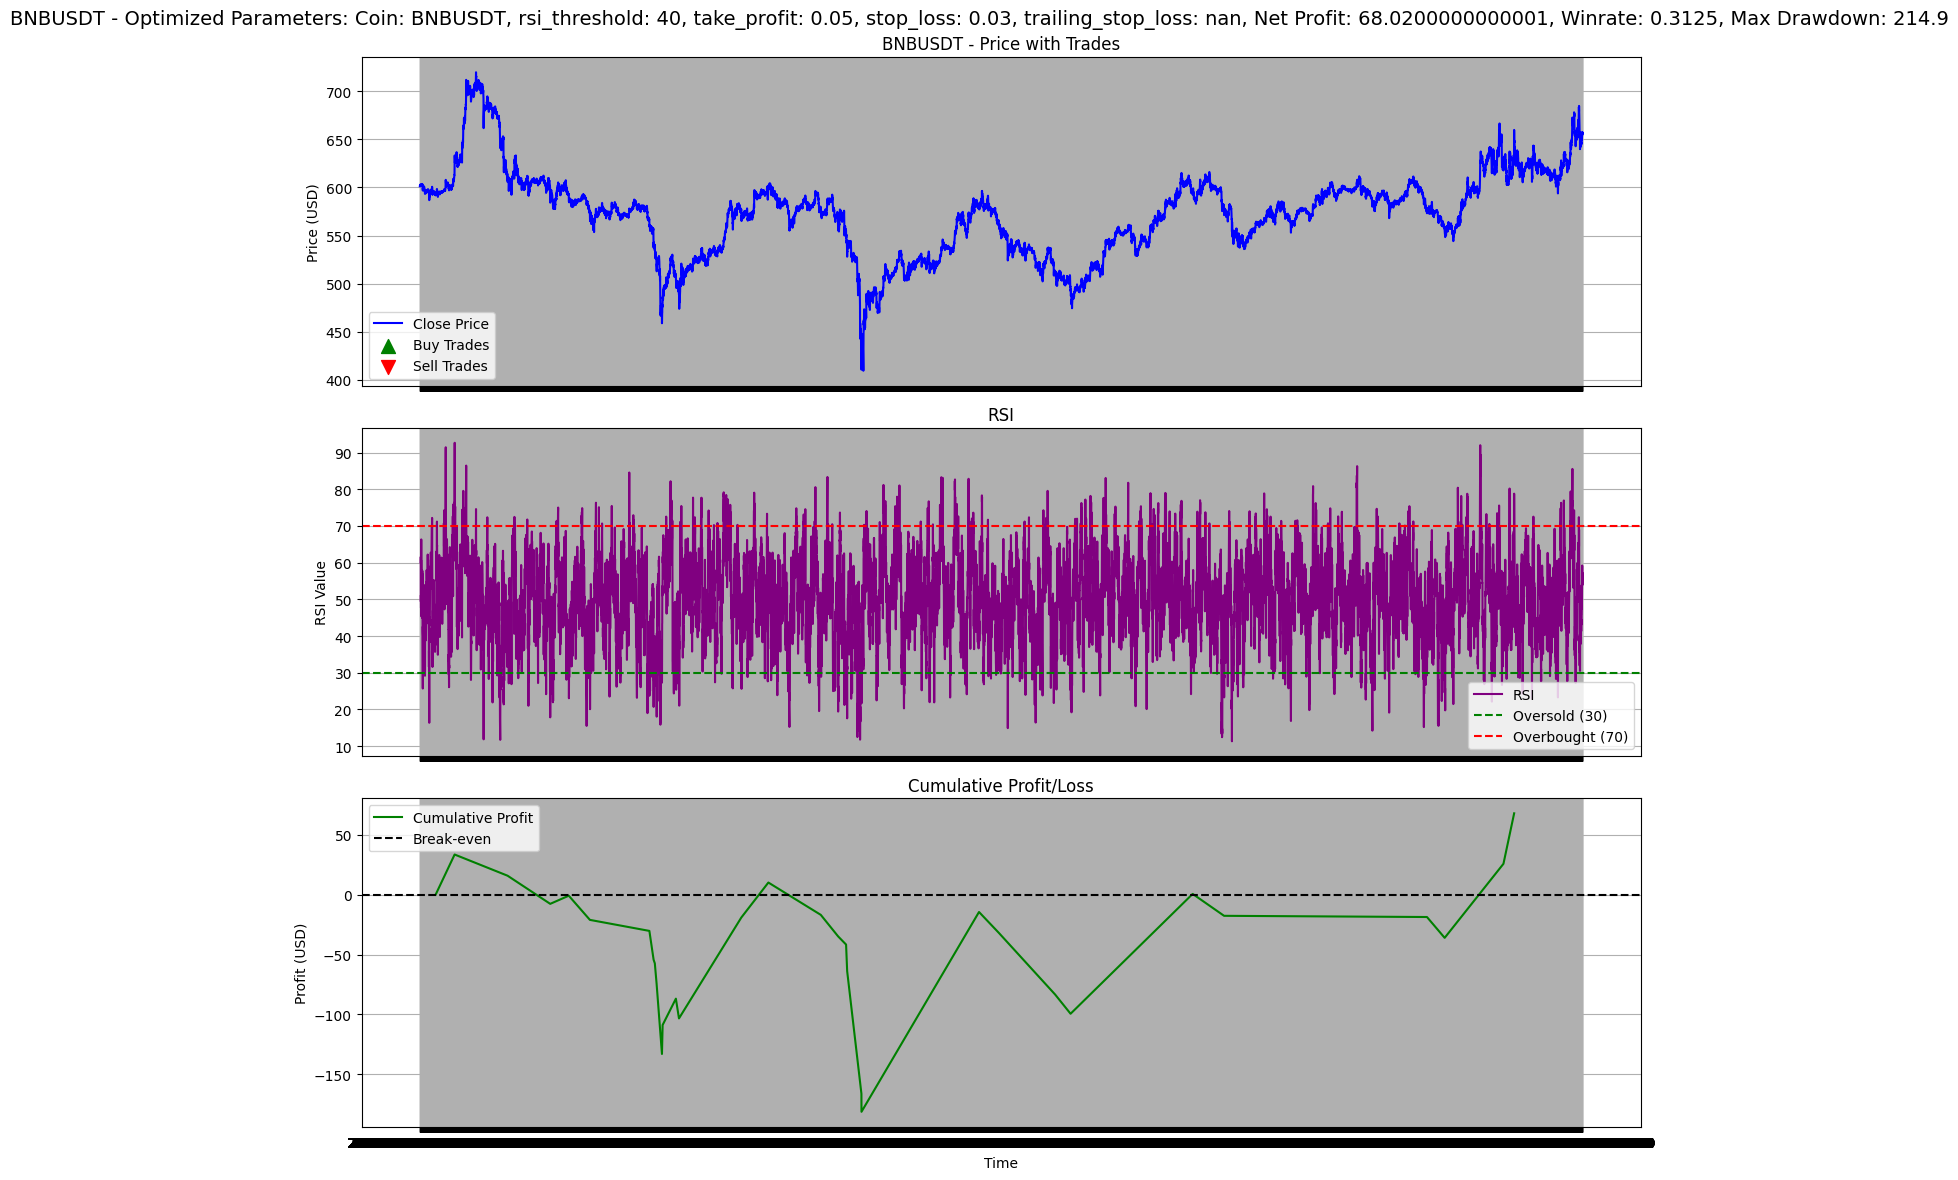

Abrufen oder Laden der Daten für XRPUSDT...
Lade historische Daten aus historical_data/XRPUSDT_15m.csv...
Optimierte Parameter für XRPUSDT gefunden: {'Coin': 'XRPUSDT', 'rsi_threshold': 35, 'take_profit': 0.02, 'stop_loss': 0.01, 'trailing_stop_loss': nan, 'Net Profit': 0.0158999999999999, 'Winrate': 0.3125, 'Max Drawdown': 0.0645999999999999}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/XRPUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/XRPUSDT_trades.csv.


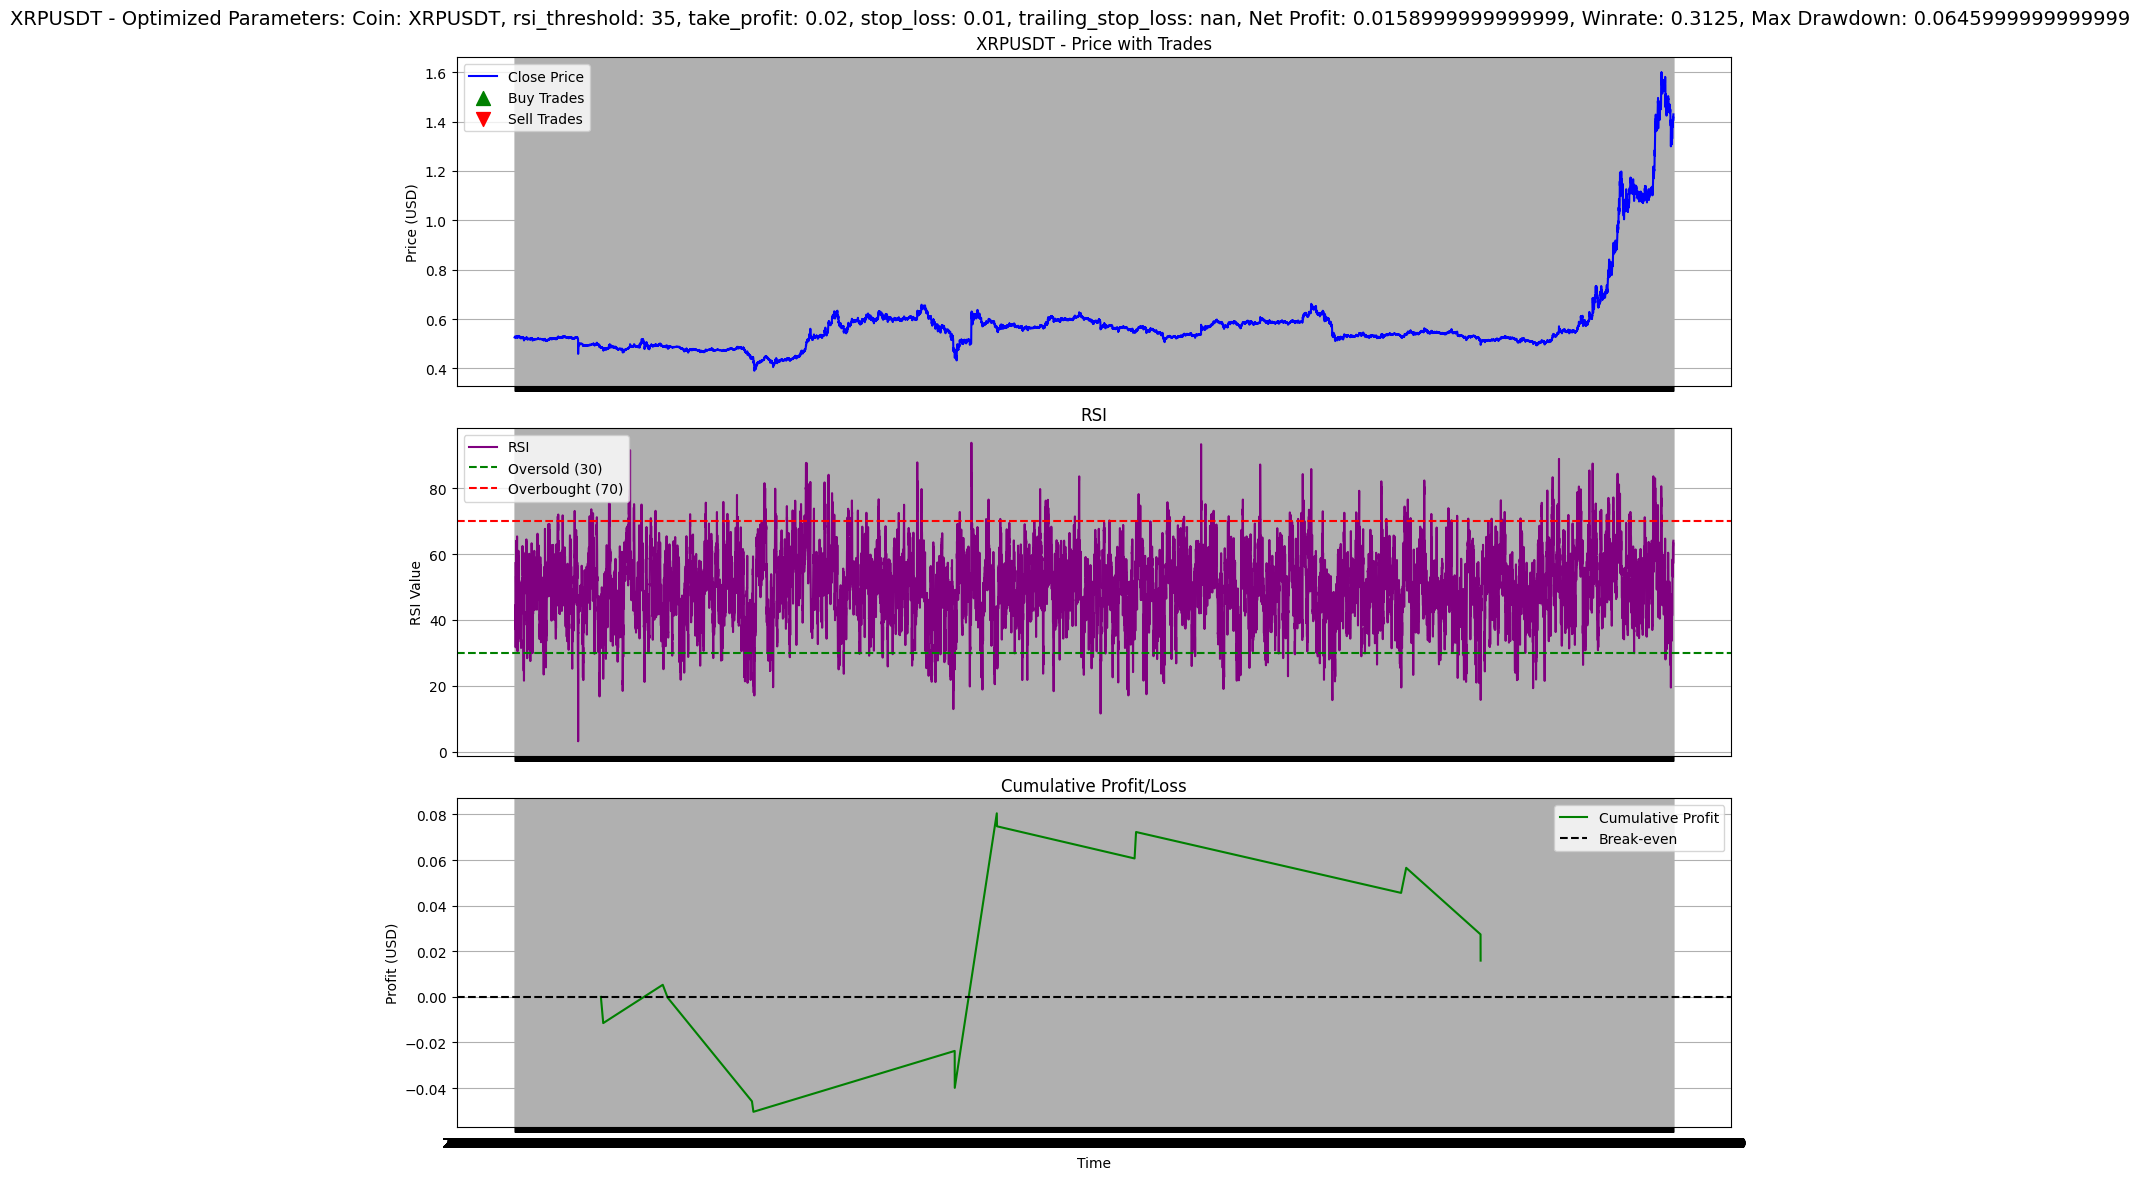

Abrufen oder Laden der Daten für DOGEUSDT...
Lade historische Daten aus historical_data/DOGEUSDT_15m.csv...
Optimierte Parameter für DOGEUSDT gefunden: {'Coin': 'DOGEUSDT', 'rsi_threshold': 40, 'take_profit': 0.05, 'stop_loss': 0.03, 'trailing_stop_loss': nan, 'Net Profit': 0.0405699999999999, 'Winrate': 0.3863636363636363, 'Max Drawdown': 0.07631}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/DOGEUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/DOGEUSDT_trades.csv.


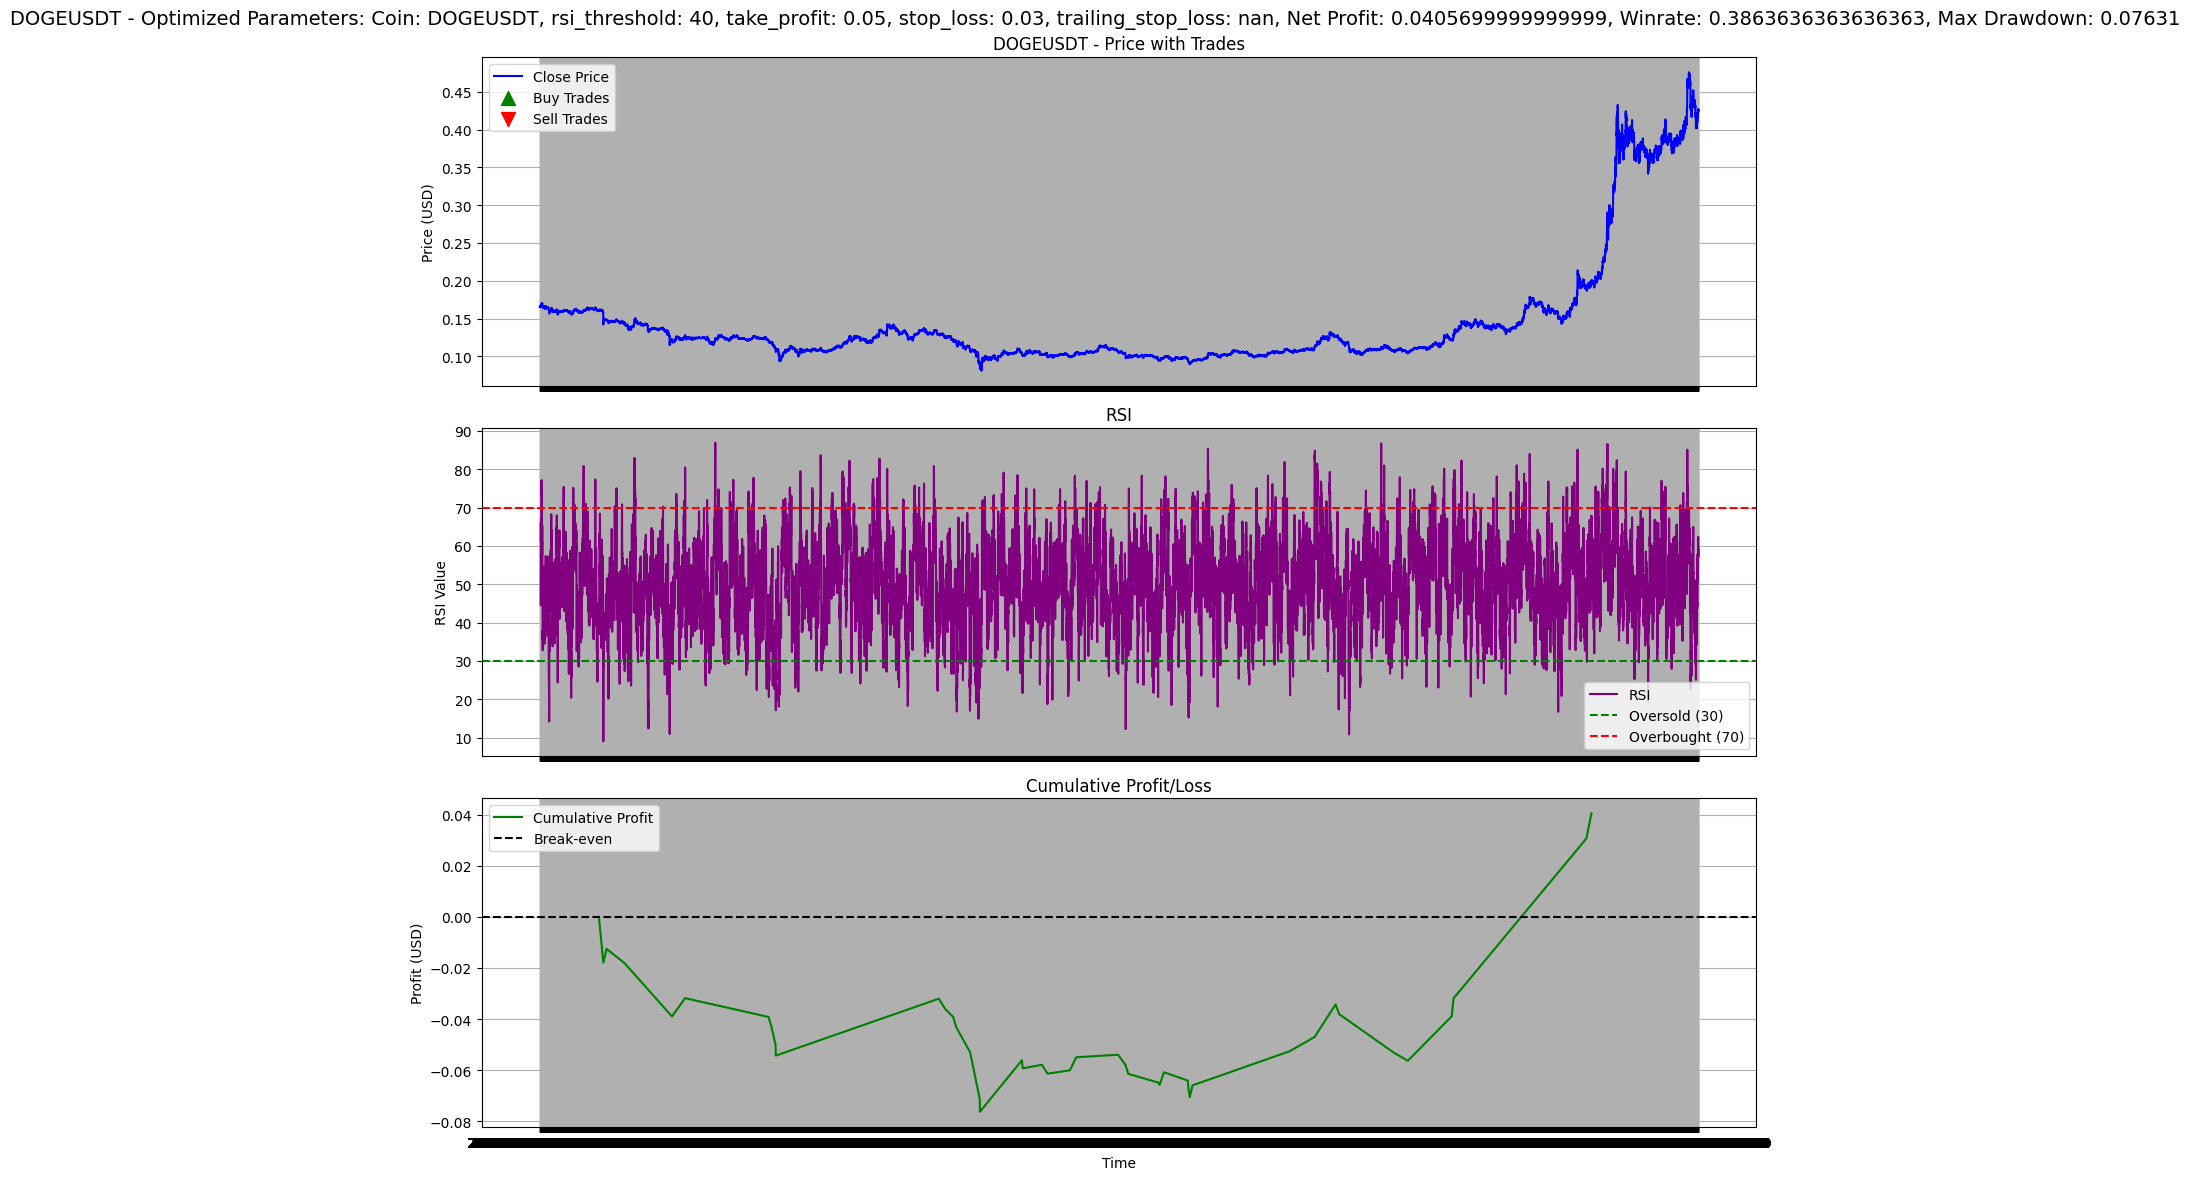

Abrufen oder Laden der Daten für USDCUSDT...
Lade historische Daten aus historical_data/USDCUSDT_15m.csv...
Optimierte Parameter für USDCUSDT gefunden: {'Coin': 'USDCUSDT', 'rsi_threshold': 20, 'take_profit': 0.02, 'stop_loss': 0.01, 'trailing_stop_loss': nan, 'Net Profit': 0.0, 'Winrate': 0.0, 'Max Drawdown': 0.0}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/USDCUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/USDCUSDT_trades.csv.
Warnung: Keine gültigen Trades für USDCUSDT.


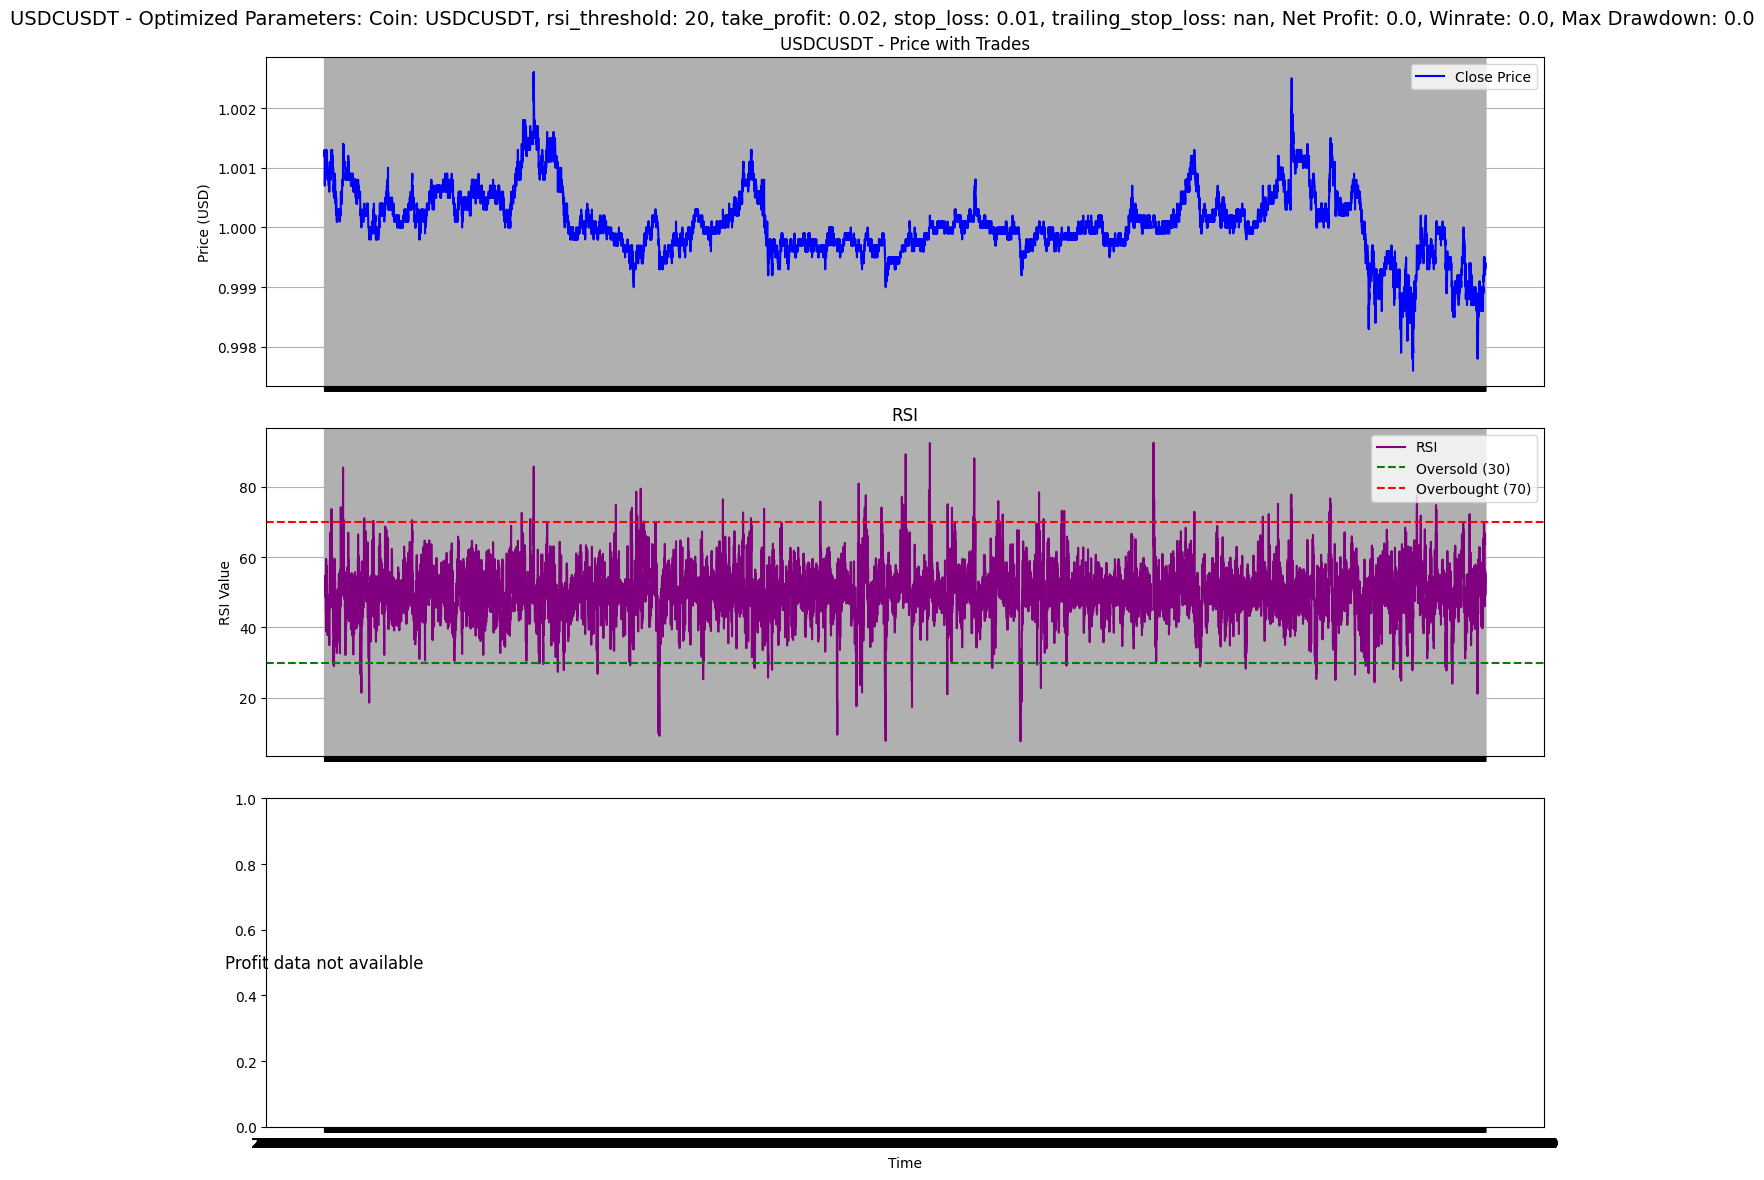

Abrufen oder Laden der Daten für ADAUSDT...
Lade historische Daten aus historical_data/ADAUSDT_15m.csv...
Optimierte Parameter für ADAUSDT gefunden: {'Coin': 'ADAUSDT', 'rsi_threshold': 20, 'take_profit': 0.02, 'stop_loss': 0.01, 'trailing_stop_loss': nan, 'Net Profit': 0.0, 'Winrate': 0.0, 'Max Drawdown': 0.0}
Optimierte Parameter gespeichert in optimized_parameters.csv.
Backtesting-Ergebnisse für backtesting_results/ADAUSDT_trades.csv nicht gefunden.
Backtesting-Ergebnisse gespeichert in backtesting_results/ADAUSDT_trades.csv.
Warnung: Keine gültigen Trades für ADAUSDT.


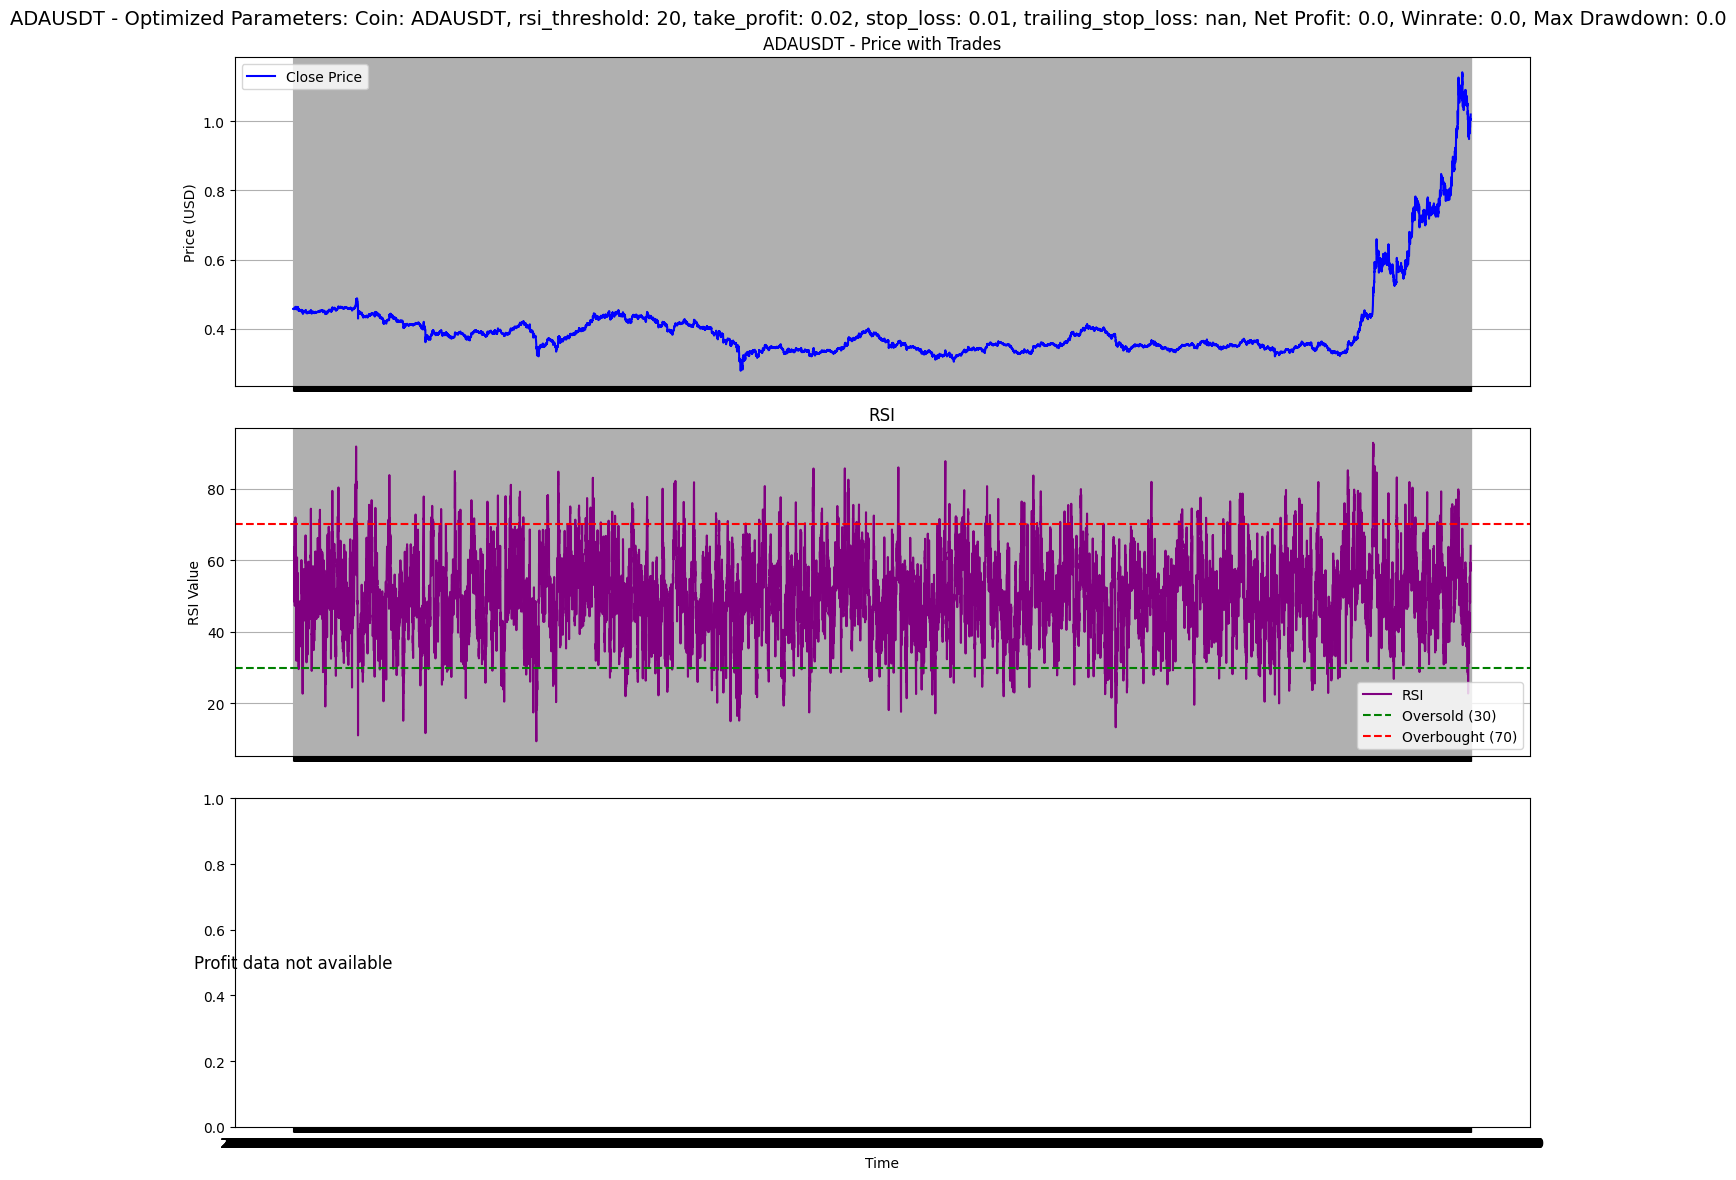

In [268]:
# Pipeline für mehrere Coins mit Speicher- und Ladefunktionen
import os
import pandas as pd

def load_optimized_parameters(file_path="optimized_parameters.csv"):
    """
    Lädt die optimierten Parameter aus einer CSV-Datei, falls vorhanden.
    
    Parameters:
        file_path (str): Pfad zur CSV-Datei mit den optimierten Parametern.

    Returns:
        list: Eine Liste von Dictionaries mit den optimierten Parametern.
    """
    if os.path.exists(file_path):
        print(f"Lade optimierte Parameter aus {file_path}...")
        return pd.read_csv(file_path).to_dict(orient="records")
    else:
        print(f"Optimierte Parameter-Datei {file_path} nicht gefunden. Starte ohne gespeicherte Parameter.")
        return []
    
# Backtesting-Ergebnisse laden oder berechnen
trades_file = f"backtesting_results/{coin}_trades.csv"
trades = load_backtesting_results(trades_file)
if trades is None:
    # Berechnen, falls Backtesting-Ergebnisse nicht existieren
    trades, performance = simulate_long_trades(
        coin_data,
        {
            "rsi_threshold": coin_optimized_params["rsi_threshold"],
            "take_profit": coin_optimized_params["take_profit"],
            "stop_loss": coin_optimized_params["stop_loss"]
        },
        debug=False
    )
    save_backtesting_results(trades, trades_file)


optimized_parameters = load_optimized_parameters("optimized_parameters.csv")  # Bereits existierende Parameter laden

for coin in coin_symbols:
    print(f"Abrufen oder Laden der Daten für {coin}...")
    file_path = f"historical_data/{coin}_15m.csv"

    # Historische Daten laden oder berechnen
    coin_data = fetch_or_load_historical_data(file_path, interval="15m", days=180)

    if coin_data is not None:
        # Berechnung der Indikatoren
        coin_data = calculate_indicators(coin_data)

        # Überprüfen, ob optimierte Parameter existieren
        coin_optimized_params = next((p for p in optimized_parameters if p["Coin"] == coin), None)
        if coin_optimized_params:
            print(f"Optimierte Parameter für {coin} gefunden: {coin_optimized_params}")
        else:
            # Parameter optimieren, falls nicht vorhanden
            best_params, _ = optimize_parameters(coin_data, debug=False)
            coin_optimized_params = {"Coin": coin, **best_params}
            optimized_parameters.append(coin_optimized_params)
            print(f"Optimierte Parameter für {coin} berechnet: {coin_optimized_params}")

        # Speichern der optimierten Parameter
        save_optimized_parameters(optimized_parameters)

        # Backtesting-Ergebnisse laden oder berechnen
        trades_file = f"backtesting_results/{coin}_trades.csv"
        trades = load_backtesting_results(trades_file)
        if trades is None:
            # Berechnen, falls Backtesting-Ergebnisse nicht existieren
            trades, performance = simulate_long_trades(
                coin_data,
                {
                    "rsi_threshold": coin_optimized_params["rsi_threshold"],
                    "take_profit": coin_optimized_params["take_profit"],
                    "stop_loss": coin_optimized_params["stop_loss"]
                },
                debug=False
            )
            save_backtesting_results(trades, trades_file)

        # Visualisierung
        plot_trades_extended(coin, coin_data, trades, params=coin_optimized_params)
    else:
        print(f"Keine Daten für {coin} verfügbar.")


### Visualisierung

In [269]:
import matplotlib.pyplot as plt

def plot_trades_extended(coin_name, coin_data, trades, params=None):
    """
    Visualisiert Preis- und Handelsdaten mit zusätzlichen Informationen wie Indikatoren und Performance.
    
    Parameters:
        coin_name (str): Name des Coins.
        coin_data (DataFrame): Historische Daten des Coins mit Indikatoren.
        trades (DataFrame): Trades mit Spalten 'Time', 'Price', 'Type', 'Profit'.
        params (dict, optional): Optimierte Parameter wie RSI, Take-Profit, Stop-Loss.
    """
    fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    
    # Preisverlauf und Trades
    axs[0].plot(coin_data["Open Time"], coin_data["Close"], label="Close Price", color="blue", linewidth=1.5)
    if not trades.empty and "Time" in trades.columns and "Price" in trades.columns:
        # Buy Trades
        buy_trades = trades[trades["Type"] == "Buy"]
        axs[0].scatter(buy_trades["Time"], buy_trades["Price"], color="green", label="Buy Trades", marker="^", s=100)
        
        # Sell Trades
        sell_trades = trades[trades["Type"] == "Sell"]
        axs[0].scatter(sell_trades["Time"], sell_trades["Price"], color="red", label="Sell Trades", marker="v", s=100)
    else:
        print(f"Warnung: Keine gültigen Trades für {coin_name}.")
    axs[0].set_title(f"{coin_name} - Price with Trades")
    axs[0].set_ylabel("Price (USD)")
    axs[0].legend()
    axs[0].grid(True)
    
    # RSI
    if "RSI" in coin_data.columns:
        axs[1].plot(coin_data["Open Time"], coin_data["RSI"], label="RSI", color="purple")
        axs[1].axhline(y=30, color="green", linestyle="--", label="Oversold (30)")
        axs[1].axhline(y=70, color="red", linestyle="--", label="Overbought (70)")
        axs[1].set_title("RSI")
        axs[1].set_ylabel("RSI Value")
        axs[1].legend()
        axs[1].grid(True)
    else:
        axs[1].text(0.5, 0.5, "RSI data not available", ha="center", va="center", fontsize=12)
    
    # Kumulierte Profite
    if "Profit" in trades.columns:
        trades["Cumulative Profit"] = trades["Profit"].cumsum()
        axs[2].plot(trades["Time"], trades["Cumulative Profit"], label="Cumulative Profit", color="green")
        axs[2].axhline(y=0, color="black", linestyle="--", label="Break-even")
        axs[2].set_title("Cumulative Profit/Loss")
        axs[2].set_ylabel("Profit (USD)")
        axs[2].legend()
        axs[2].grid(True)
    else:
        axs[2].text(0.5, 0.5, "Profit data not available", ha="center", va="center", fontsize=12)
    
    # Optimierte Parameter im Titel
    if params:
        param_text = ", ".join([f"{key}: {value}" for key, value in params.items()])
        fig.suptitle(f"{coin_name} - Optimized Parameters: {param_text}", fontsize=14)
    
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()
